In [1]:
# !pip install datasets
# !pip install transformers
# !pip install nltk
# !pip install rogue_metrics
# !pip install py7zr

# Chapter6 요약
## 6.1 CNN/DailyMail 데이터셋

In [2]:
from datasets import load_dataset

dataset = load_dataset("cnn_dailymail", version="3.0.0")
print(f"특성: {dataset['train'].column_names}")

특성: ['article', 'highlights', 'id']


In [58]:
sample = dataset["train"][1]
print(f"""기사 (500개 문자 발췌, 총 길이: {len(sample['article'])}):""")
print(sample["article"][:500])
print(f"\n요약 (길이: {len(sample['highlights'])}):")
print(sample["highlights"])

기사 (500개 문자 발췌, 총 길이: 4051):
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most s

요약 (길이: 281):
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .


In [59]:
print(dataset["train"][1]["article"])

Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most severe mental illnesses are incarcerated until they're ready to appear in court. Most often, they face drug charges or charges of assaulting an officer --charges that Judge Steven Leifman says are usually "avoidable felonies." He says the arrests often result from confrontations with police. Mentally ill people often won't do what they're told when police arrive on the scene -- confrontation seems to exacerbate their illness and they become more paranoid, delusional, and less likely to follow dir

## 6.2 텍스트 요약 파이프라인

In [4]:
sample_text = dataset["train"][1]["article"][:2000]
# 딕셔너리에 각 모델이 생성한 요약을 저장합니다.
summaries = {}

In [5]:
for sample in dataset["train"]:
    if sample["article"].startswith("(CNN)  -- Usain Bolt rounded"):
        print(sample["article"])
        break

In [6]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")

string = "The U.S. are a country. The U.N. is an organization."
sent_tokenize(string)

[nltk_data] Downloading package punkt to C:\Users\Kang
[nltk_data]     MinJae\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['The U.S. are a country.', 'The U.N. is an organization.']

In [7]:
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktParameters

string = "Fig. 2 shows a U.S.A. map."

print(sent_tokenize(string))

punkt_param = PunktParameters()
abbreviation = ['u.s.a', 'fig']
punkt_param.abbrev_types = set(abbreviation)
tokenizer = PunktSentenceTokenizer(punkt_param)

print(tokenizer.tokenize(string))

['Fig.', '2 shows a U.S.A. map.']
['Fig. 2 shows a U.S.A. map.']


### 6.2.1 요약 기준 모델

In [8]:
def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])

summaries["baseline"] = three_sentence_summary(sample_text)

### 6.2.2 GPT-2

In [9]:
from transformers import pipeline, set_seed

set_seed(42)

pipe = pipeline("text-generation", model="gpt2-xl")
gpt2_query = sample_text + "\nTL;DR:\n"
pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)
summaries["gpt2"] = "\n".join(
    sent_tokenize(pipe_out[0]["generated_text"][len(gpt2_query) :]))

A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [10]:
summaries

{'baseline': 'Editor\'s note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.\nHere, Soledad O\'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.\nMIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."',
 'gpt2': 'Here\'s a more "interesting" story CNN.com was unable to access.\nThis story in the Miami Herald\xa0 is even more disturbing.\nA video report at 6:00 \xa0of Leifman\'s office shows a video of a mentally ill inmate breaking through the bars of a jail cell and making a break for it.\nThe\xa0 Miami Herald headline above tells you everything'}

## 6.2.3 T5

In [11]:
pipe = pipeline("summarization", model="t5-large")
pipe_out = pipe(sample_text)
summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

c:\Users\Kang MinJae\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\t5\tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


### 6.2.4 BART

In [12]:
pipe = pipeline("summarization", model="facebook/bart-large-cnn")
pipe_out = pipe(sample_text)
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

### 6.2.5 PEGASUS

In [13]:
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")
pipe_out = pipe(sample_text)
summaries["pegasus"] = pipe_out[0]["summary_text"].replace(" .<n>", ".\n")

## 6.3 요약 결과 비교하기

In [14]:
print("GROUD TRUTH")
print(dataset["train"][1]["highlights"])
print("")

for model_name in summaries:
    print(model_name.upper())
    print(summaries[model_name])
    print("")

GROUD TRUTH
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .

BASELINE
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.
Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.
MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."

GPT2
Here's a more "interesting" story CNN.com was unable to access.
This story in the Miami Herald  is even more disturbing.
A video report at 6:00  of Leifman's office shows a video of a mentally ill inmate breaking throug

## 6.4 생성된 텍스트 품질 평가하기
### 6.4.1 BLEU
생성된 텍스트에서 얼마나 많은 토큰이 참조 텍스트 토큰과 완벽하게 똑같이 정렬됐는지 확인하는 대신, 단어 또는 n-그램을 체크합니다. 정밀도를 근간으로 하는 지표인데, 두 텍스트를 비교할 때 참조 텍스트에 있는 단어가 생성된 텍스트에 얼마나 자주 등장하는지 카운트하고, 생성된 텍스트 길이로 나눕니다.

여기엔 문제가 있는데, 생성된 텍스트에 동일 단어가 반복되고 이 단어가 참조 텍스트에 등장하면, 정밀도가 1이 됩니다. 따라서 BLEU 논문에서는 단어를 참조 텍스트에 등장한 횟수만큼만 카운트합니다.

예를 들어 참조 텍스트와 생성된 텍스트가 아래와 같을 때, 정밀도는 수식과 같이 계산됩니다. \
\
참조 텍스트 : `the cat is on the mat` \
생성된 텍스트 : `the the the the the the`

$$p_{vanilla} = {6\over6}$$
$$p_{mod} = {2\over6}$$

이를 확장하여, 단어 뿐만 아니라 n-그램도 확인할 수 있습니다. \
생성된 텍스트를 $snt$, 참조 문장을 $snt'$라고 할 때, n-그램에 대한 정밀도를 다음과 같이 계산합니다.

$$
p_n = {{\sum_{n-gram \in snt'}Count_{clip}(n-gram)}\over{\sum_{n-gram \in snt}Count_(n-gram)}}
$$

반복적인 생성에는 점수를 주지 않도록 분자의 카운트는 클리핑합니다. 앞에서 언급했듯이, 생성된 문장에서 n-그램의 등장 횟수를 카운트 하는 것이 참조 문장에 나타난 횟수로 제한된다는 의미입니다.

일반적으로 테스트 세트는 평가할 샘플이 하나 이상이기 때문에 말뭉치 $C$에 있는 모든 샘플에 대해서는 식이 다음과 같이 확장됩니다.

$$
p_n = {{\sum_{snt' \in C}\sum_{n-gram \in snt'}Count_{clip}(n-gram)}\over{\sum_{snt \in C}\sum_{n-gram \in snt}Count_(n-gram)}}
$$

위 식은 재현율은 고려하지 않기 때문에 짧은 시퀀스가 긴 문장보다 유리합니다. 따라서 **브레비티 페널티**(brevity penalty)가 도입되었습니다.

$$
BR = min(1, e^{1-\ell_{ref}/\ell_{gen}})
$$

생성된 텍스트의 길이 $\ell_{gen}$가 참조 텍스트 $\ell_{ref}$보다 더 짧을 때 때 지수 항이 작아집니다. 따라서 BP의 값도 작아집니다. \
재현율을 고려하지 않는 이유는 번역 데이터셋에는 보통 여러 개의 참조 문장이 있는데, 재현율을 측정할 경우 참조 문장에 있는 단어를 모두 사용할 경우 가산점이 부여되기 때문입니다.

예를 들어 `Good Morning` 이라는 문장을 한국어로 번역할 때, 데이터셋에 다음과 같이 참조 문장이 세 개가 있다고 가정합니다.
1. 안녕하세요!
2. 좋은 아침이에요!
3. 아침이 밝았어요!

이 때, 번역된 문장이 `안녕하세요! 좋은 아침이 밝았어요!`와 같이 번역되면 더 높은 점수가 부여되는 문제가 있습니다.

앞에서 고려한 모든 것을 합친 BLEU 점수는 다음과 같이 계산합니다.

$$
\textrm{BLEU}-N = BR \times \left(\prod_{n=1}^N p_n \right)^{1/N}
$$

BLEU는 동의어를 고려하지 않는다는 단점이 있습니다. 그리고 매 단계에서 한계가 존재합니다.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive

def brevity_penalty(c, r):
    BP = 1 if c > r else np.exp(1 - r / c)
    
    c_values = np.linspace(0.1, 2 * max(c, r), 400)  
    BP_values = np.where(c_values > r, 1, np.exp(1 - r / c_values))
    
    plt.figure(figsize=(10, 6), dpi=100)
    plt.plot(c_values, BP_values, label='Brevity Penalty curve', color='blue')
    plt.axhline(y=1, color='gray', linestyle='--', lw=0.5)
    plt.axvline(x=r, color='red', linestyle='--', label=f'Reference Length (r) = {r}')
    plt.axvline(x=c, color='green', linestyle='--', label=f'Candidate Length (c) = {c}')
    plt.scatter(c, BP, color='black', s=70, zorder=5)
    plt.xlabel('Candidate Length')
    plt.ylabel('Brevity Penalty (BP)')
    plt.title('Brevity Penalty as function of Candidate Length')
    plt.legend()
    plt.grid(True)
    plt.ylim([0, 1.1])
    plt.show()

interactive_plot = interactive(brevity_penalty, c=(1, 100), r=(1, 100))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=50, description='c', min=1), IntSlider(value=50, description='r', min=1)…

In [16]:
ref_len = 50
can_lens = [5, 25, 50, 100, 150]

print("참조 문장의 길이         생성된 문장의 길이         브레비티 페널티")
for can_len in can_lens:
    BP = 1 if can_len > ref_len else np.exp(1 - ref_len / can_len)
    print(f"{ref_len:<23} {can_len:<25} {BP}")


참조 문장의 길이         생성된 문장의 길이         브레비티 페널티
50                      5                         0.00012340980408667956
50                      25                        0.36787944117144233
50                      50                        1.0
50                      100                       1
50                      150                       1


In [17]:
import pandas as pd
import numpy as np
from datasets import load_metric

bleu_metric = load_metric("sacrebleu")

C:\Users\Kang MinJae\AppData\Local\Temp\ipykernel_14632\2101912569.py:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric("sacrebleu")


In [18]:
from evaluate import load

bleu_metric_new = load("sacrebleu")

In [19]:
results = bleu_metric_new.compute(
        predictions=["the the the the the the"], references=[["the cat is on the mat"]], 
        smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]

df = pd.DataFrame.from_dict(results, orient="index", columns=["Value"])
df

,Value
score,0.0
counts,"[2, 0, 0, 0]"
totals,"[6, 5, 4, 3]"
precisions,"[33.33, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,6
ref_len,6


In [20]:
descriptions = {
    "score": "최종 BLEU 점수",
    "counts": "매칭된 n-그램의 개수",
    "totals": "가능한 n-그램의 총 개수",
    "precisions": "각 n-그램에 대한 정밀도",
    "bp": "브레비티 페널티 값",
    "sys_len": "생성된 텍스트의 길이",
    "ref_len": "참조 텍스트의 길이"
}

bleu_metric.add(
    prediction="the the the the the the", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]

df = pd.DataFrame.from_dict(results, orient="index", columns=["Value"])
df["Description"] = df.index.map(descriptions)  # Map keys to descriptions

df

,Value,Description
score,0.0,최종 BLEU 점수
counts,"[2, 0, 0, 0]",매칭된 n-그램의 개수
totals,"[6, 5, 4, 3]",가능한 n-그램의 총 개수
precisions,"[33.33, 0.0, 0.0, 0.0]",각 n-그램에 대한 정밀도
bp,1.0,브레비티 페널티 값
sys_len,6,생성된 텍스트의 길이
ref_len,6,참조 텍스트의 길이


`smooth_value`를 사용하면 분자에 상수 값을 추가합니다. `smooth_method="floor"`일 경우 `smooth_value`는 $0.1$이 됩니다. \
즉 분자에 $+0.1$을 하여 $p_n$을 다음과 같이 계산합니다.

$$
p_n = \frac{\text{n-grams count in reference text} + \text{smooth value(=0.1)}}{\text{n-grams in generated text}}
$$

따라서 bigram에서 겹치는 bigram이 하나도 없지만, 아래와 같이 `smooth_value`에 의해 precision이 $\frac{0.1}{5} = 0.02$로 계산됩니다.

In [21]:
bleu_metric.add(
    prediction="the the the the the the", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor")
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]

df = pd.DataFrame.from_dict(results, orient="index", columns=["Value"])
df["Description"] = df.index.map(descriptions)  # Map keys to descriptions

df

,Value,Description
score,4.854918,최종 BLEU 점수
counts,"[2, 0, 0, 0]",매칭된 n-그램의 개수
totals,"[6, 5, 4, 3]",가능한 n-그램의 총 개수
precisions,"[33.33, 2.0, 2.5, 3.33]",각 n-그램에 대한 정밀도
bp,1.0,브레비티 페널티 값
sys_len,6,생성된 텍스트의 길이
ref_len,6,참조 텍스트의 길이


In [22]:
bleu_metric.add(
    prediction="the cat is on mat", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]

df = pd.DataFrame.from_dict(results, orient="index", columns=["Value"])
df

,Value
score,57.893007
counts,"[5, 3, 2, 1]"
totals,"[5, 4, 3, 2]"
precisions,"[100.0, 75.0, 66.67, 50.0]"
bp,0.818731
sys_len,5
ref_len,6


### 6.4.2 ROUGE

ROGUE 점수는 정밀도보다 재현율이 정확한 요약 같은 태스크를 위해 개발되었습니다. n-그램이 얼마나 자주 등장하는지 비교한다는 점에서 BLEU 점수와 비슷하지만, 참조 텍스트에 있는 n-그램이 생성된 텍스트에 얼마나 많이 등장하는지도 확인한다는 점이 다릅니다. 다음이 원래 ROUGE 점수 공식입니다.

$$
\textrm{ROUGE}-N = {{\sum_{snt' \in C}\sum_{n-gram \in snt'}Count_{match}(n-gram)}\over{\sum_{snt' \in C}\sum_{n-gram \in snt'}Count_(n-gram)}}
$$

그런데 정밀도를 완전히 제거하면 부정적인 영향이 커짐을 발견하였고, 클리핑 카운트를 하지 않는 BLEU 공식으로 돌아가 정밀도를 측정한 다음 위의 ROUGE식에서 구한 재현율 점수를 조화 평균한 $\textrm{F}_1$-점수를 ROUGE 점수로 사용합니다.

ROUGE는 가장 긴 공통 부분 시퀀스(longest common subsequence, LCS)를 측정하는 별도의 점수인 ROUGE-L이 있습니다. 두 샘플 사이에서 이 값을 비교할 때, 긴 텍스트가 유리하므로 정규화가 필요합니다. 그래서 ROUGE 개발자는 F-점수와 같은 방식을 고안하였고, 다음과 같이 참조 텍스트와 생성 텍스트의 길이로 LCS를 정규화한 다음 정규화된 점수를 혼합합니다.

$$
R_{LCS} = \frac{LCS(X, Y)}{m}
$$

$$
P_{LCS} = \frac{LCS(X, Y)}{n}
$$

$$
F_{LCS} = \frac{(1 + \beta^2)R_{LCS}P_{LCS}}{R_{LCS}+\beta^2P_{LCS}} ~~~~~~~~ (\textrm{where, }\beta = P_{LCS} / R_{LCS})
$$

In [23]:
rouge_metric = load_metric("rouge")

In [24]:
reference = dataset["train"][1]["highlights"]
records = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

for model_name in summaries:
    rouge_metric.add(predictions=summaries[model_name], reference=reference)
    score = rouge_metric.compute()
    rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
    records.append(rouge_dict)

pd.DataFrame.from_records(records, index=summaries.keys())

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.365079,0.145161,0.206349,0.285714
gpt2,0.288288,0.018349,0.162162,0.288288
t5,0.382979,0.130435,0.255319,0.382979
bart,0.475248,0.222222,0.316832,0.415842
pegasus,0.323232,0.206186,0.282828,0.323232


## 6.5 CNN/DailyMail 데이터셋에서 PEGASUS 평가하기

In [25]:
def evaluate_summaries_baseline(dataset, metric,
                                column_text="article",
                                column_summary="highlights"):
    summaries = [three_sentence_summary(text) for text in dataset[column_text]]
    metric.add_batch(predictions=summaries,
                     references=dataset[column_summary])
    score = metric.compute()
    return score

In [26]:
test_sampled = dataset["test"].shuffle(seed=42).select(range(1000))

score = evaluate_summaries_baseline(test_sampled, rouge_metric)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)

pd.DataFrame.from_dict(rouge_dict, orient="index", columns=["baseline"]).T

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.389276,0.171296,0.245061,0.354239


In [27]:
from tqdm.auto import tqdm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

def chunks(list_of_elements, batch_size):
    """ list_of_elements로부터 batch_size 크기의 청크를 연속적으로 생성합니다. """
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

def evaluate_summaries_pegasus(dataset, metric, model, tokenizer,
                               batch_size=16, device=device,
                               column_text="article",
                               column_summary="highlights"):
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):

        inputs = tokenizer(article_batch, max_length=1024, truncation=True,
                           padding="max_length", return_tensors="pt")
        
        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                                   attention_mask=inputs["attention_mask"].to(device),
                                   length_penalty=0.8, num_beams=8, max_length=128)
        
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                              clean_up_tokenization_spaces=True)
                            for s in summaries]
        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
    
    score = metric.compute()
    return score

In [28]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)
# 아래 코드는 실행 시간이 너무 오래 걸려서 생략
'''
score = evaluate_summaries_pegasus(test_sampled, rouge_metric,
                                   model, tokenizer, batch_size=8)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)

pd.DataFrame(rouge_dict, index=["pegasus"])
'''

'\nscore = evaluate_summaries_pegasus(test_sampled, rouge_metric,\n                                   model, tokenizer, batch_size=8)\nrouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)\n\npd.DataFrame(rouge_dict, index=["pegasus"])\n'

## 6.6 요약 모델 훈련하기

In [29]:
dataset_samsum = load_dataset("samsum")
split_lengths = [len(dataset_samsum[split]) for split in dataset_samsum]

print(f"분할 크기: {split_lengths}")
print(f"특성: {dataset_samsum['train'].column_names}")
print("\n대화:")
print(dataset_samsum["test"][0]["dialogue"])
print("\n요약:")
print(dataset_samsum["test"][0]["summary"])

분할 크기: [14732, 819, 818]
특성: ['id', 'dialogue', 'summary']

대화:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

요약:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


### 6.6.1 SAMSum에서 PEGASUS 평가하기

In [30]:
pipe_out = pipe(dataset_samsum["test"][0]["dialogue"])
print(pipe_out[0]["summary_text"].replace(" .<n>", ".\n")) 

Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Amanda: Ask Larry Amanda: He called her last time we were at the park together.
Hannah: I'd rather you texted him.
Amanda: Just text him .


In [31]:
# 실행시간이 너무 오래걸려서 생략
score = evaluate_summaries_pegasus(dataset_samsum["test"], rouge_metric, model,
                                   tokenizer, column_text="dialogue",
                                   column_summary="summary", batch_size=8)

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

### 6.6.2 PEGASUS 미세 튜닝하기

Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 1024). Running this sequence through the model will result in indexing errors


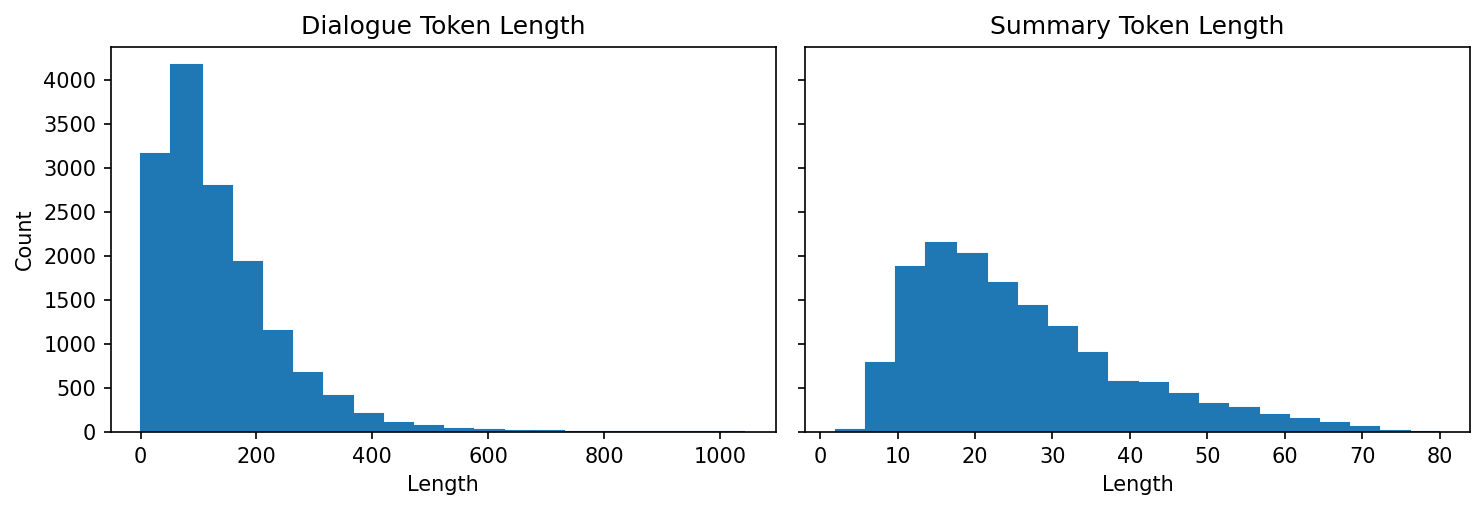

In [32]:
d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True, dpi=150)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [33]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024,
                                truncation=True)
    
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=128,
                                     truncation=True)
    
    return {"input_ids": input_encodings["input_ids"],
            "attention_mask": input_encodings["attention_mask"],
            "labels": target_encodings["input_ids"]}

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, 
                                       batched=True)

columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

c:\Users\Kang MinJae\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\tokenization_utils_base.py:3606: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [34]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [35]:
from transformers import TrainingArguments, Trainer


training_args = TrainingArguments(
    output_dir = f"D:/_MODEL_CHECKPOINT/pegasus-samsum",
    num_train_epochs=1,
    warmup_steps=500,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    weight_decay=0.01,
    logging_steps=10,
    evaluation_strategy="steps",
    eval_steps=500,
    save_steps=1e6,
    gradient_accumulation_steps=16)

In [36]:
trainer = Trainer(model=model, args=training_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"],
                  eval_dataset=dataset_samsum_pt["validation"])

In [ ]:
# 실행시간이 너무 오래걸려서 생략
trainer.train()

In [ ]:
# 실행시간이 너무 오래걸려서 생략
score = evaluate_summaries_pegasus(
    dataset_samsum["test"], rouge_metric, trainer.model, tokenizer,
    batch_size=2, column_text="dialogue", column_summary="summary")

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

### 6.6.3 대화 요약 생성하기

In [ ]:
gen_kwargs = {"length_penalty": 0.8, "num_beams": 8, "max_length": 128}
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]

pipe = pipeline("summarization", model=model) # 체크포인트 불러와야 함

print("대화:")
print(sample_text)
print("\n참조 요약:")
print(reference)
print("\n모델 요약:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])